# SacFC - Full Season Training Dataset
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Jan 24, 2022

## Hypothesis


## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
lkupclientid = 31 # Sacfc
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMLS].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(11698, 54)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11698 entries, 0 to 11697
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   lkupClientId            11698 non-null  int64  
 1   dimCustomerMasterId     11698 non-null  int64  
 2   customerNumber          765 non-null    object 
 3   year                    11698 non-null  int64  
 4   productGrouping         11698 non-null  object 
 5   totalSpent              11698 non-null  float64
 6   recentDate              11698 non-null  object 
 7   attendancePercent       11698 non-null  float64
 8   renewedBeforeDays       11698 non-null  int64  
 9   isBuyer                 11698 non-null  object 
 10  source_tenure           11698 non-null  int64  
 11  tenure                  11698 non-null  int64  
 12  distToVenue             0 non-null      object 
 13  totalGames              11698 non-null  int64  
 14  recency                 11698 non-null

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = [
    "dimCustomerMasterId",
                "attendancePercent",
                "clickToOpenRatio",
                "clickToSendRatio",
                "distToVenue",
                "email",
                "inperson_contact",
                "internal_note",
                "left_message",
                "missed_games_1",
                "missed_games_2",
                "missed_games_over_2",
                "totalSpent",
                "openToSendRatio",
                "phonecall",
                "recency",
                "source_tenure",
                "renewedBeforeDays",
                "isNextYear_Buyer",
                "productGrouping",
                "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]
df_dataset = df_dataset[df_dataset["productGrouping"] ==  'Full Season' ]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (5461, 21)
Unseen Data For Predictions: (964, 21)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
    "attendancePercent",
                "clickToOpenRatio",
                "clickToSendRatio",
                "distToVenue",
                "email",
                "inperson_contact",
                "internal_note",
                "left_message",
                "missed_games_1",
                "missed_games_2",
                "missed_games_over_2",
                "totalSpent",
                "openToSendRatio",
                "phonecall",
                "recency",
                "source_tenure",
                "renewedBeforeDays"
    ]
);

In [7]:
model_matrix = compare_models(
    fold=10,
    include=["lr", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8261,0.8480,0.9214,0.8600,0.8896,0.4829,0.4897,0.4660
lr,Logistic Regression,0.7722,0.7472,0.9691,0.7829,0.8660,0.1598,0.2137,0.4860


In [8]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8194,0.8390,0.9405,0.8405,0.8877,0.4335,0.4520
1,0.8448,0.8530,0.9318,0.8723,0.9011,0.5429,0.5493
2,0.8427,0.8734,0.9205,0.8780,0.8988,0.5470,0.5500
3,0.8341,0.8450,0.9261,0.8647,0.8944,0.5096,0.5161
4,0.7759,0.8025,0.8977,0.8229,0.8587,0.3219,0.3292
5,0.8103,0.8364,0.9091,0.8511,0.8791,0.4413,0.4465
6,0.8556,0.8838,0.9377,0.8803,0.9081,0.5730,0.5792
7,0.8297,0.8513,0.9122,0.8703,0.8907,0.5063,0.5092
8,0.8405,0.8541,0.9207,0.8760,0.8978,0.5361,0.5395
9,0.8082,0.8415,0.9178,0.8438,0.8792,0.4172,0.4261


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

### Let's load in our 2021 season data and get retention scores using the model:

In [9]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference[df_inference["productGrouping"] ==  'Full Season' ]
df_inference = df_inference.fillna(0)
df_inference.shape

(2366, 54)

In [10]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,...,education,urbanicity,credits_after_refund,is_Lockdown,NumberofGamesPerSeason,CNTPostponedGames,isNextYear_Buyer,Label,Score_0,Score_1
8743,31,457921261,0,2021,Full Season,906.96,2021-09-18,0.177778,38,TRUE,...,0,0,0.00,1,24,0,0,1,0.0104,0.9896
8744,31,457921287,0,2021,Full Season,966.72,1970-01-01,0.000000,402,TRUE,...,0,0,468.28,1,24,0,0,0,0.5074,0.4926
8745,31,457921422,0,2021,Full Season,1351.92,2021-09-18,0.361111,381,TRUE,...,0,0,0.00,1,24,0,0,1,0.0497,0.9503
8746,31,457921457,107097,2021,Full Season,72.22,2021-10-13,1.000000,511,TRUE,...,0,0,0.00,1,24,0,0,1,0.0287,0.9713
8748,31,457921864,0,2021,Full Season,932.64,2021-10-30,1.076923,357,TRUE,...,0,0,0.00,1,24,0,0,1,0.1908,0.8092


In [11]:
new_predictions["Label"].value_counts()

1    2266
0     100
Name: Label, dtype: int64

In [12]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(0.8, 1.0]       2045
(0.6, 0.8]        172
(0.4, 0.6]         84
(0.2, 0.4]         44
(-0.001, 0.2]      21
Name: Score_1, dtype: int64

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

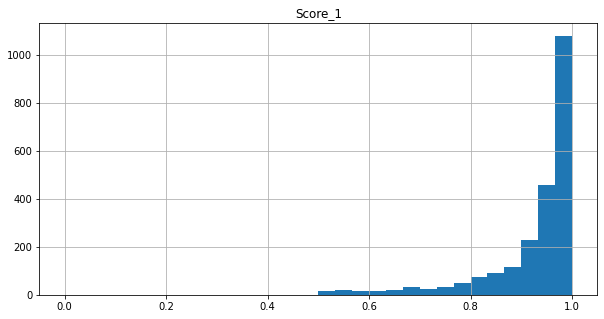

In [13]:
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

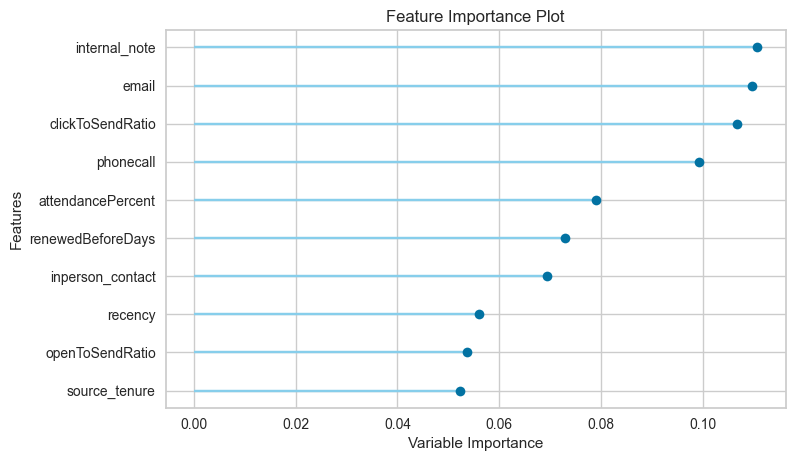

In [14]:
plot_model(best_model, plot='feature')

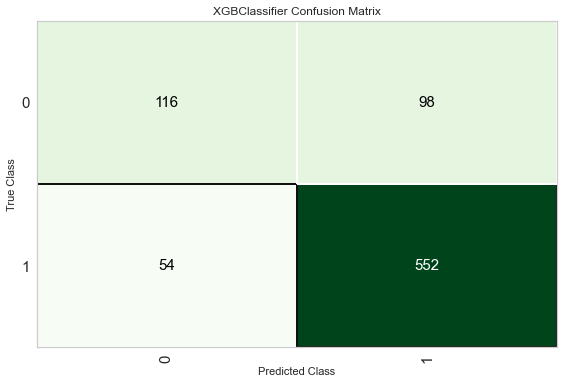

In [15]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above

* The distribtution looks normal (as expected)
* Touchpoint data has the first 2 features and the third one is marketing data
* Ticketing data follows up at the next 2 features
* The model makes a lot more predictions of customers who will buy
* The accuracy increased by 1% compared to using all products but AUC decreased by 1%
